Cuts in the collaboration have traditionally come in two forms: "manual" cuts, and autocuts.

"Manual" cuts are great in some ways: writing down the cut is really fast. Unfortunately, along with the cuts, you typically want to show collaborators a number of plots, e.g. example events passing and failing the cut, the events passing and failing in OFAmp vs. Chi2 space, etc. I (Roger Romani) made a notebook to do this in the summer of 2022, but it was slow, partially due to inherent problems with the speed of Pandas dataframes we were using at the time, and partially due to the type of visualizations I was using (scatter plots vs. heatmaps).

Manual cuts also require the analyzer to figure out where to set the cut level. For one dataset, it's pretty easy to figure out where to put the e.g. baseline cut, and if you need to adjust the cut to get say 90% passage, it's not too bad. However, this quickly becomes impracticle when doing cuts for dozens of datasets.

Autocuts are also great in other ways. They are to most analyzers a black box, so there's essentially no thinking involved, and especially with recent updates give quite good results most of the time. However, they are slow (taking days to analyze large datasets) and until recently there was very little people could do to tune the cuts or diagnose problems with them. Autocuts will remain a valuable tool for fast low effort analyzes (e.g. doing a first pass at a PSD) but are far from ideal for final analyzes where we want to understand everything in excrutiating detail. 

-------------

This is where the new semiautocuts tool comes in. As the name implies, it intends to be only slightly more difficult to use than autocuts, to be as fast computationally as manual cuts (or even faster, thanks to Vaex!), and to automatically produce a range of typical plots you want to look at to determine the effectiveness of the cut.

This notebook demonstrates some of the functionality of semiautocuts. It was made in May 2023 by Roger Romani, feel free to reach out with questions. At the moment, semiautocuts is fairly rough, and there are likely a large number of potentially useful functions that are missing. Hopefully, future collaborators continue to update and improve semiautocuts!


In [1]:
#first, some imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 6.5]

#import things associated with detanalysis including semiautocut
import vaex as vx
from detanalysis import Analyzer, Semiautocut, MasterSemiautocuts

#for reading in data
from pytesdaq.io.hdf5 import H5Reader
import pytesdaq.io.hdf5 as h5io
h5 = h5io.H5Reader()

Now, let's load in some data to take a look at. This data is real data from the 0.25% device in Run 26. We'll be specifically doing cuts on the Left channel, so this data is triggered on the Left channel only.

In [2]:
#location of the rq files generated with detprocess
file_path = '/sdata1/runs/run26/processed/rqgen_feature_I2_D20230405_T154904'

#location of the triggered data on which detprocess was run. Used for plotting
#example events
path_to_triggered_data = '/sdata1/runs/run26/processed/triggered_I2_D20230405_T134718'

myanalyzer = Analyzer(file_path, series=None)

# show number of events 
myanalyzer.describe()

#df is the vaex dataframe with all the RQs
df = myanalyzer.df

Number of files: 1
Number of events: 11293
Number of features: 69
Is DataFrame filtered? False
No cuts have been registered!
No derived features have been added!


/home/roger/.local/lib/python3.6/site-packages/h5py/_hl/files.py:457: ResourceWarning: unclosed file <_io.BufferedReader name='/sdata1/runs/run26/processed/rqgen_feature_I2_D20230405_T154904/rqgen_feature_I2_D20230405_T134718_F0001.hdf5'>
  h5i.dec_ref(id_)
/usr/lib64/python3.6/asyncio/base_events.py:527: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)


Just so we know what we're working with, let's print out all the names of the columns in the Vaex dataframe. This will be nice so we can copy and paste them later.

In [3]:
print(df.get_column_names())

['amp_of1x1_constrained_Melange025pcLeft', 'amp_of1x1_constrained_Melange025pcRight', 'amp_of1x1_constrained_didv_Melange025pcLeft', 'amp_of1x1_constrained_didv_Melange025pcRight', 'amp_of1x1_constrained_single_Melange025pcLeft', 'amp_of1x1_constrained_single_Melange025pcRight', 'amp_of1x1_nodelay_Melange025pcLeft', 'amp_of1x1_nodelay_Melange025pcRight', 'amp_of1x1_nodelay_didv_Melange025pcLeft', 'amp_of1x1_nodelay_didv_Melange025pcRight', 'amp_of1x1_nodelay_single_Melange025pcLeft', 'amp_of1x1_nodelay_single_Melange025pcRight', 'baseline_Melange025pcLeft', 'baseline_Melange025pcRight', 'baseline_end_Melange025pcLeft', 'baseline_end_Melange025pcRight', 'chi2_of1x1_constrained_Melange025pcLeft', 'chi2_of1x1_constrained_Melange025pcRight', 'chi2_of1x1_constrained_didv_Melange025pcLeft', 'chi2_of1x1_constrained_didv_Melange025pcRight', 'chi2_of1x1_constrained_single_Melange025pcLeft', 'chi2_of1x1_constrained_single_Melange025pcRight', 'chi2_of1x1_nodelay_Melange025pcLeft', 'chi2_of1x1_nod

Now, let's start with the actual cuts. In this collaboration, for very basic analyses we start with a baseline cut, then a slope, and then do a cut in the chi2 vs ofamp space. That's what'll be demonstrated here.

--------------------------------- 

We'll start with a baseline cut.

At the most basic level, what we need to pass semiautocuts to do a cut is a pandas dataframe, the name of the RQ that the cut will be performed on, the name of the channel the cut will be done on, and some information about how we want to set the cut levels. This is set by the cut_pars dictionary (with the same format as used for autocuts, for compatability reasons). 

--------------------------------

You can currently specify cuts in 4 ways. From the semiautocuts documentation:

-val_upper/val_lower: either or both can be used to set the cut level in the same units as the cut rq is in.

-sigma / sigma_upper/sigma_lower: either the symmetric value of sigma at which the data is cut outside, or the upper and lower bounds for the sigma cut. Note that the place to cut is determined by assuming the data is gaussian centered around the median, and that the width of the distribution is set by the interquartile range (IQR) rather than by the true std, which can be pulled by outliers.

-percent / percent_upper/percent_lower: either the percent of data to pass symmetrically around the median, or the percentile above and below which to pass data. This is the true percentile of data to pass, so for percent_upper=0.6,  percent_lower=0.4, 20% of the data is passed -val_upper/val_lower: value above and/or below which to pass data.

-time_arr: array of time pairs between which to pass data.

In this case, we'll use sigma_upper to just cut events where extra bias power is coming in (from noise, etc.).

In [4]:
cut_pars_baseline = {'sigma_upper':1.4}


baseline_cut = Semiautocut(df, cut_rq = 'baseline', channel_name='Melange025pcLeft',
                               cut_pars=cut_pars_baseline)

Cut name: cut_baseline_Melange025pcLeft


Now, we need to actually do the cut. This is done by do_cut, which returns an array cut mask for convenience. You can turn diagnostic messages on or off using the lgcdiagnostics boolean.

In [5]:
bcut_mask = baseline_cut.do_cut(lgcdiagnostics=True)

include_previous_cuts: False
 
 
include_previous_cuts: False
Using default cut parameters
Selection list: ['_lims_mask']
Cut parameters: {'sigma_upper': 1.4}
Number of events passing selection: 11293
Upper limit for cuts: -7.060391872838398e-08


Now, the cut is done! We could technically go on our merry way now. However, you really need to look at some plots to check that the cut worked correctly.

Let's start by plotting the cut as a function of time:

Cut names to include in with cuts plot: 
['cut_baseline_Melange025pcLeft']


/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:856: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):
/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:861: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(yexpression):


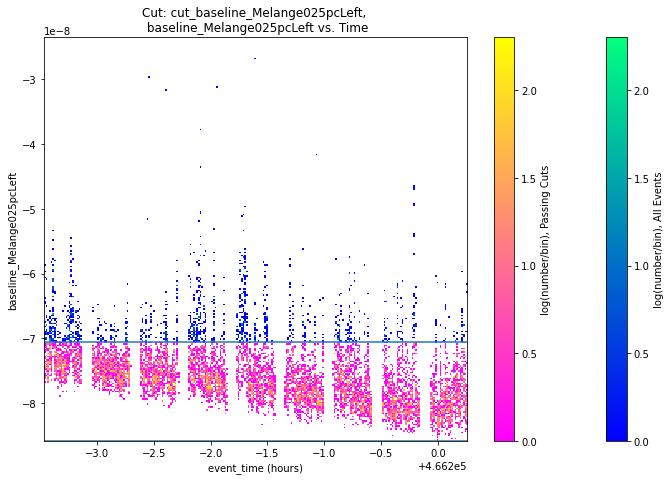

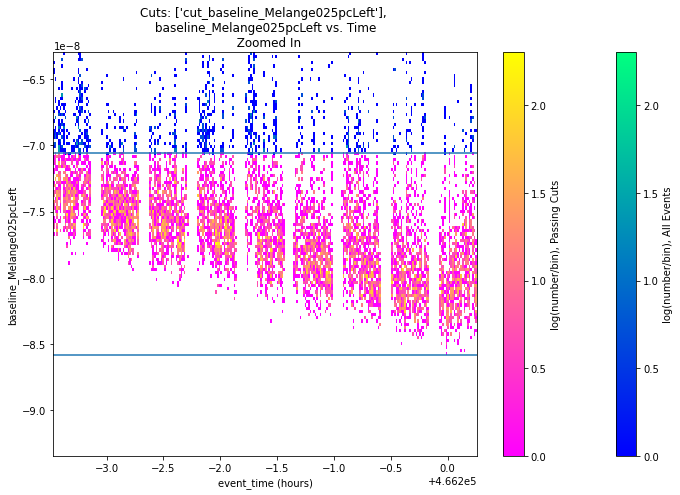

In [6]:
baseline_cut.plot_vs_time(lgchours=True, lgcdiagnostics=True)
#lgchours puts the time in units of hours rather than seconds

It looks like this data was taken early in the run, where the bias power (and therefore the baseline) were changing significantly over time. Our current cut does pretty well at first, but by the end passes a lot of bad events.

For this reason, semiautocuts includes the ability to bin in time, so we can define the cut levels separately in each time bin. Since this dataset includes 9 time series (20 min series, over the course of 3 hours), let's divide it into 9 time bins. The default is to divide the times equally by number of events, but you can also give an array with the start times of each bin.

In [7]:
baseline_cut = Semiautocut(df, cut_rq = 'baseline', channel_name='Melange025pcLeft',
                               cut_pars=cut_pars_baseline, time_bins=9)
bcut_mask = baseline_cut.do_cut(lgcdiagnostics=True)

Cut name: cut_baseline_Melange025pcLeft
Constructed time bin array: [1.67830752e+09 1.67830913e+09 1.67831068e+09 1.67831220e+09
 1.67831369e+09 1.67831525e+09 1.67831682e+09 1.67831828e+09
 1.67831978e+09]
include_previous_cuts: False
 
 
 
On bin 0
 
include_previous_cuts: False
Using default cut parameters
Binning by time, [1678307521.0646744, 1678309134.2645433]
Selection list: ['_lims_mask']
Cut parameters: {'sigma_upper': 1.4}
Number of events passing selection: 1247
Upper limit for cuts: -6.867808126768914e-08
 
 
On bin 1
 
include_previous_cuts: False
Using default cut parameters
Binning by time, [1678309134.2645433, 1678310675.0280912]
Selection list: ['_lims_mask']
Cut parameters: {'sigma_upper': 1.4}
Number of events passing selection: 1256
Upper limit for cuts: -7.176556199347759e-08
 
 
On bin 2
 
include_previous_cuts: False
Using default cut parameters
Binning by time, [1678310675.0280912, 1678312195.0738952]
Selection list: ['_lims_mask']
Cut parameters: {'sigma_upper'

Now, let's replot the cut vs. time to see how it looks:

Cut names to include in with cuts plot: 
['cut_baseline_Melange025pcLeft']


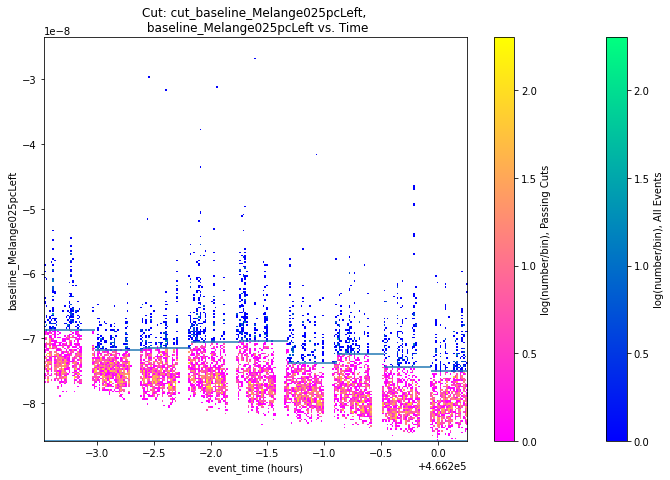

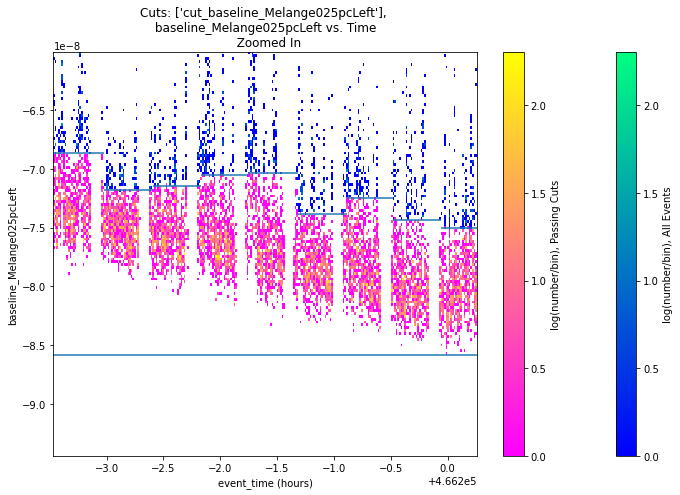

In [8]:
baseline_cut.plot_vs_time(lgchours=True, lgcdiagnostics=True)

This looks better, but there are still issues. It looks like in the fourth, fifth and seventh bins, there's so much extra noise that the cut levels are too high. We can manually set these bins to have a bit tighter cut levels while automatically generating the rest.

We do this with a dictionary called exceptions_dict, this lists the bins and new cut_pars for these bins that we want treated differently.

Cut name: cut_baseline_Melange025pcLeft
Constructed time bin array: [1.67830752e+09 1.67830913e+09 1.67831068e+09 1.67831220e+09
 1.67831369e+09 1.67831525e+09 1.67831682e+09 1.67831828e+09
 1.67831978e+09]


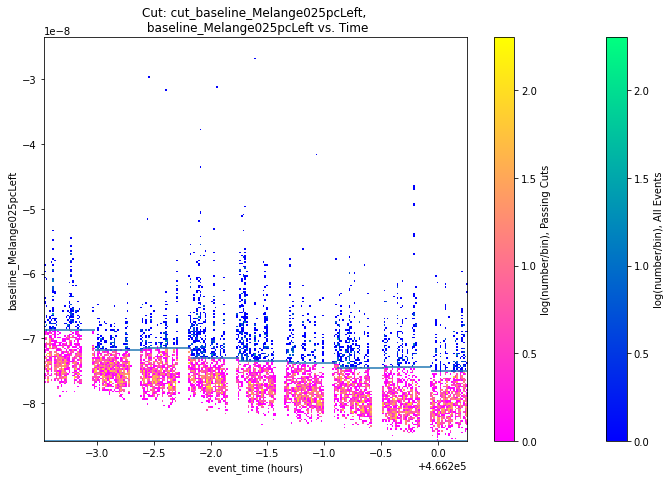

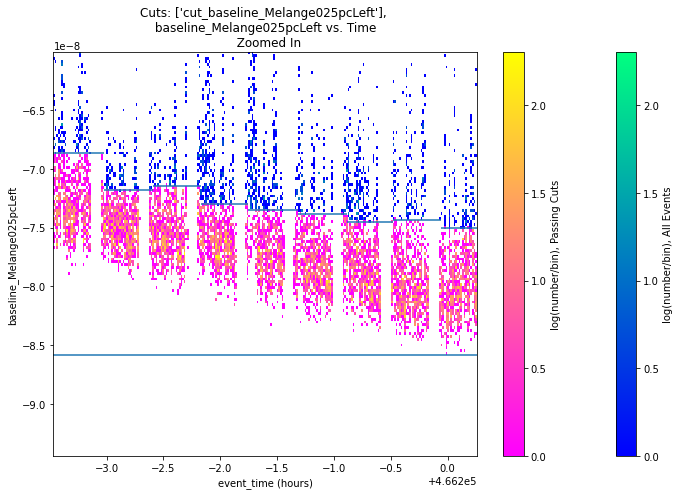

In [9]:
exceptions_dict = {3: {'val_upper': -7.3e-8}, 4 : {'val_upper': -7.35e-8}, 6 : {'val_upper': -7.45e-8}}

baseline_cut = Semiautocut(df, cut_rq = 'baseline', channel_name='Melange025pcLeft',
                               cut_pars=cut_pars_baseline, time_bins=9, exceptions_dict=exceptions_dict)
bcut_mask = baseline_cut.do_cut(lgcdiagnostics=False)
baseline_cut.plot_vs_time(lgchours=True, lgcdiagnostics=False)

That looks a bit better. Theoretically, we could go through and tune all of the bins this way, but for the sake of simplicity we won't.

Let's do a few more plots to see how this cut looks:

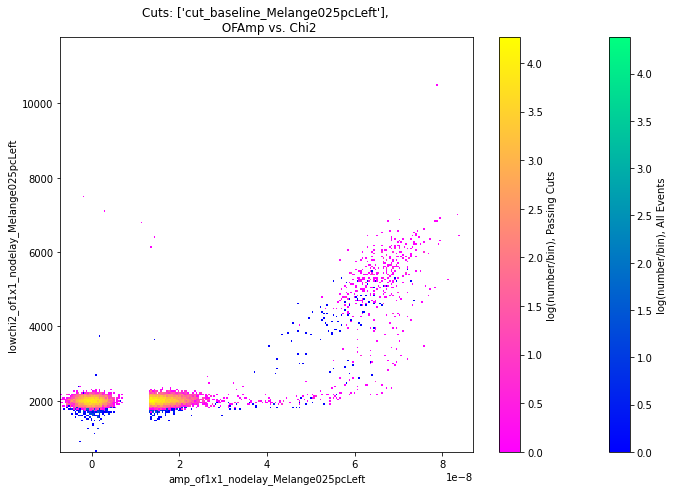

/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:189: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):
/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:189: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):


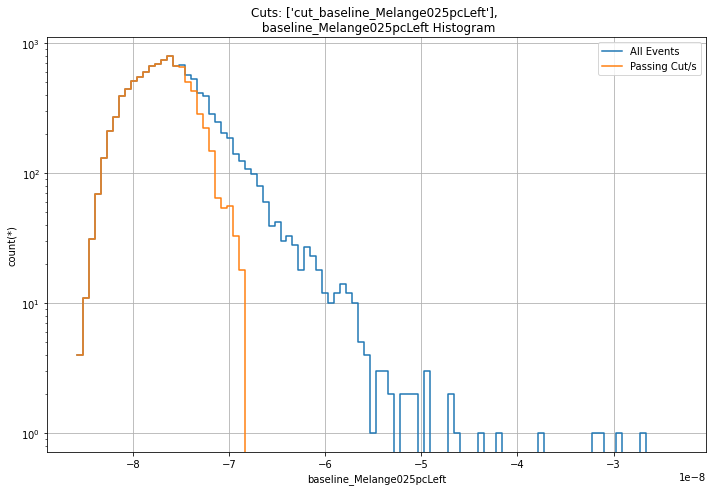

In [10]:
baseline_cut.plot_chi2_vs_ofamp()
baseline_cut.plot_histograms()

 We can also look at events which pass and fail this cut. In some cases, it's nice to be able to look at the pulses after they're low pass filterted, so we'll include a lp_freq flag to set the low pass filter frequency.

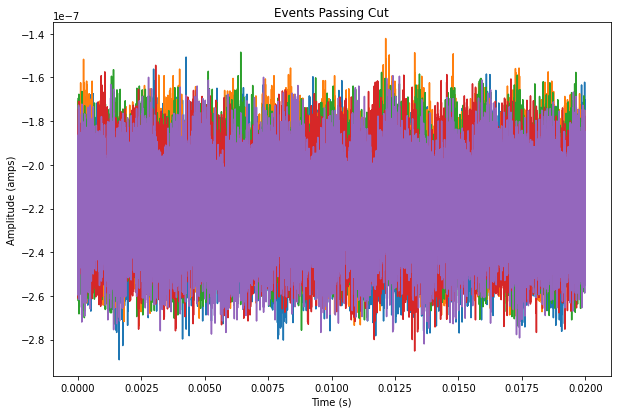

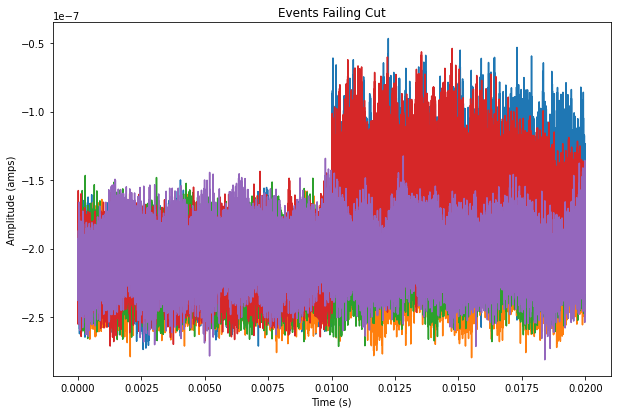

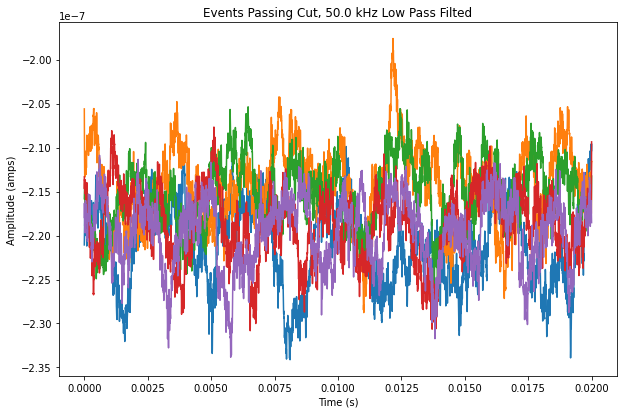

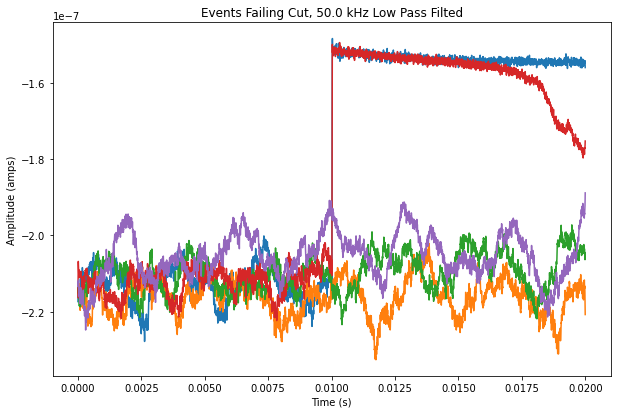

In [11]:
baseline_cut.plot_example_events(num_example_events=5, trace_index=3,
                                     path_to_triggered_data=path_to_triggered_data,
                                     lp_freq=50e3, 
                                     lgcdiagnostics=False)

Great! Time to move on to other cuts.

--------------------- 

Let's now do the slope cuts. These are pretty similar to the baseline cuts above, so I won't discuss them much.

Cut name: cut_slope_Melange025pcLeft


/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:856: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):
/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:861: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(yexpression):


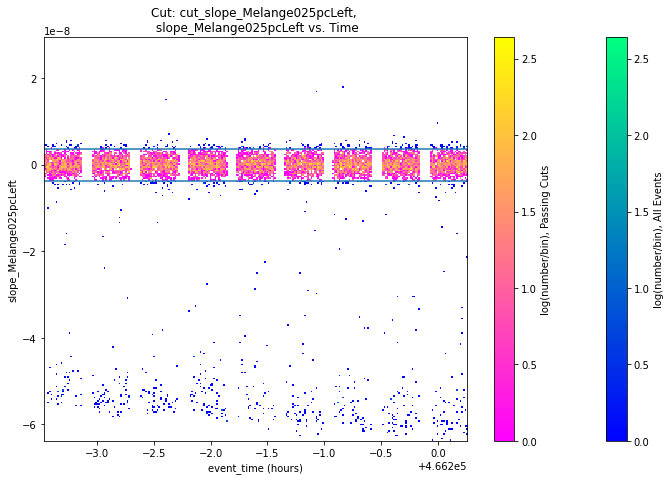

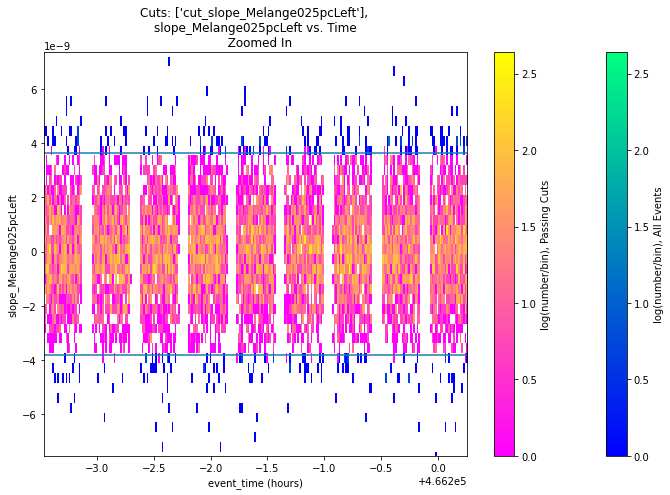

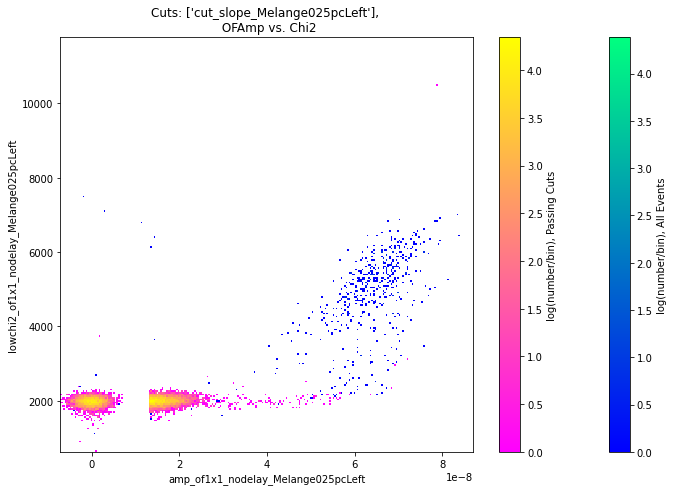

/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:189: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):
/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:189: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):


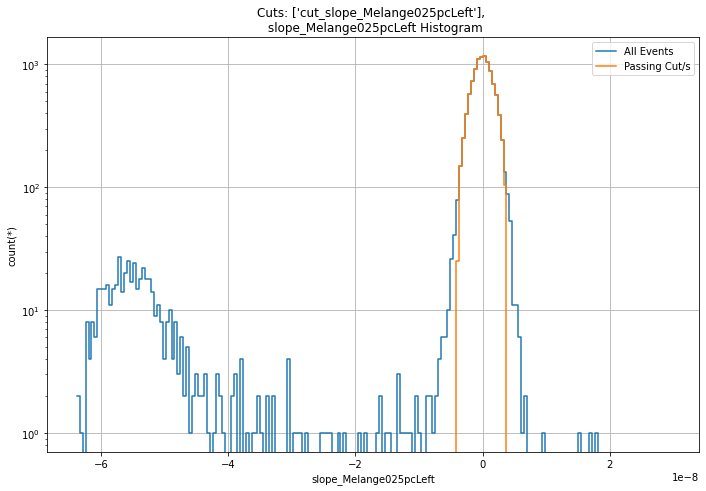

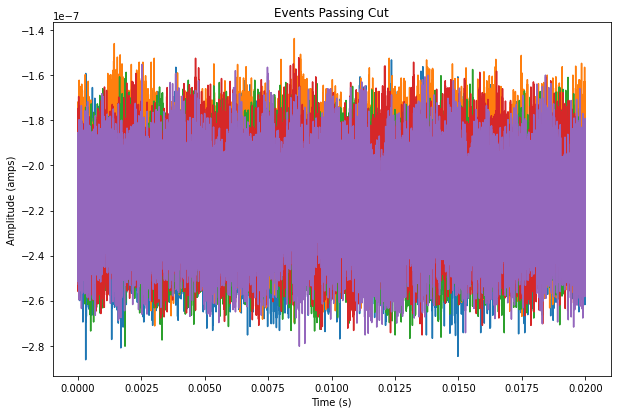

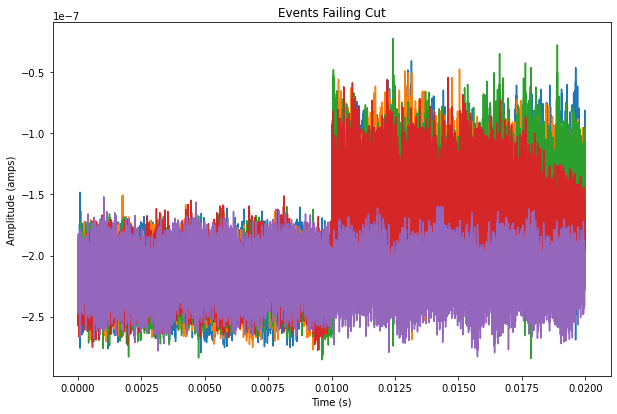

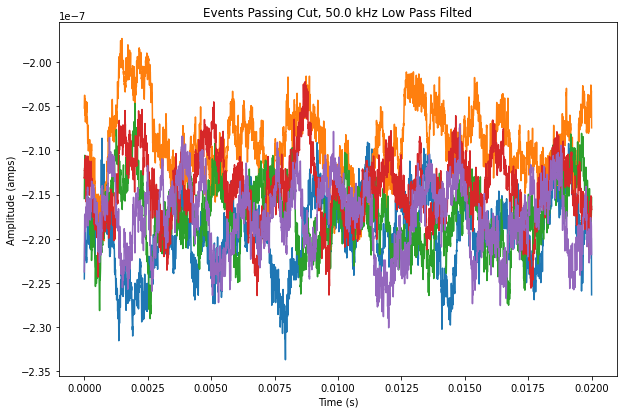

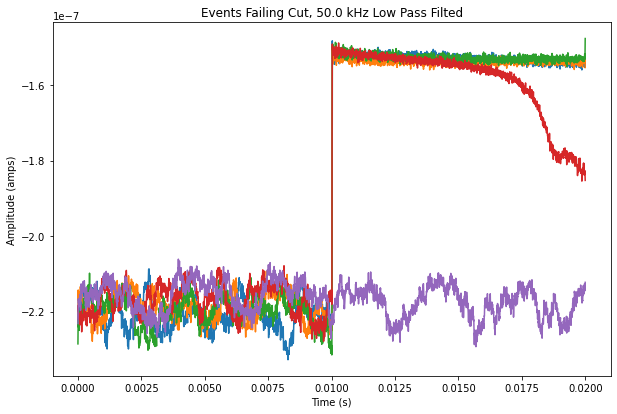

In [12]:
#first, we have to define a slope RQ:
df['slope_Melange025pcLeft'] = df['baseline_Melange025pcLeft'] - df['baseline_end_Melange025pcLeft']

#now, let's actually do the cuts

cut_pars_slope = {'sigma': 2.0}

slope_cut = Semiautocut(df, cut_rq = 'slope', channel_name='Melange025pcLeft',
                               cut_pars=cut_pars_slope)
slopecut_mask = slope_cut.do_cut(lgcdiagnostics=False)
slope_cut.plot_vs_time(lgchours=True, lgcdiagnostics=False)
slope_cut.plot_chi2_vs_ofamp()
slope_cut.plot_histograms(num_bins=200)
slope_cut.plot_example_events(num_example_events=5, trace_index=3,
                                     path_to_triggered_data=path_to_triggered_data,
                                     lp_freq=50e3, 
                                     lgcdiagnostics=False)


Now, let's do cuts in OFAmp vs. Chi2 space. Here, I'll set up my cuts into just three bins: under OFAmp = 0, over OFAmp = 0 but not saturated, and saturated. I'll manually set my cuts for the saturated bin, so we don't cut saturated events. We'll also include the previous cuts, to make the automatically generated first two bins reasonable.

Cut name: cut_lowchi2_of1x1_nodelay_Melange025pcLeft


/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:856: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):
/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:861: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(yexpression):


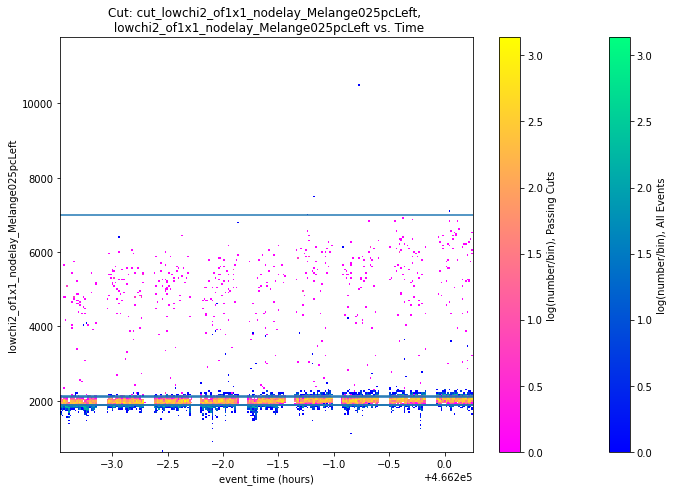

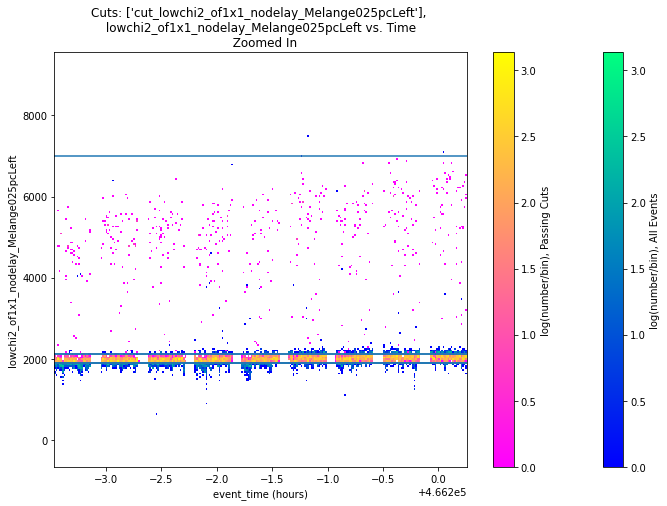

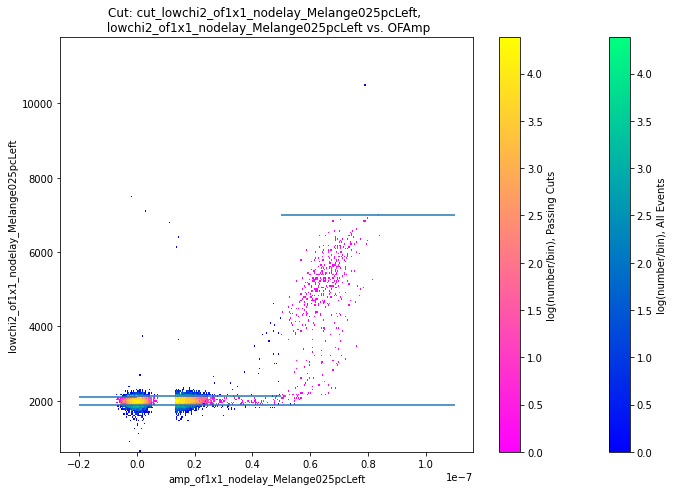

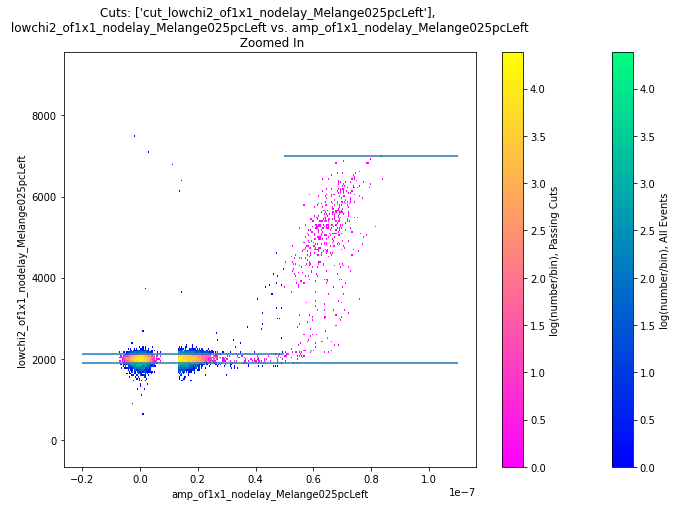

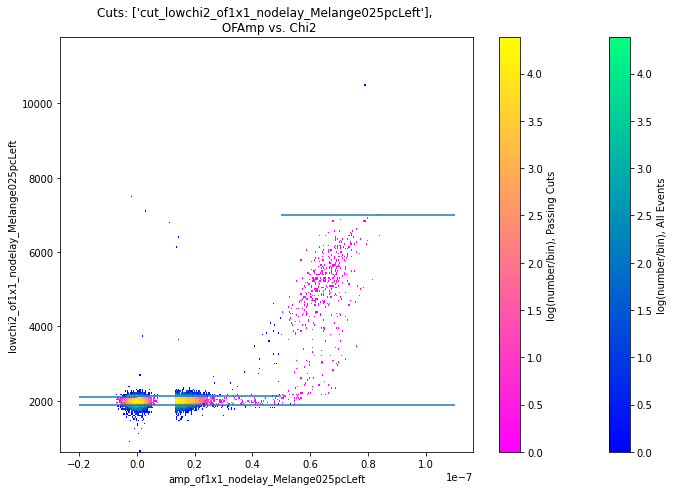

/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:189: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):
/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:189: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):


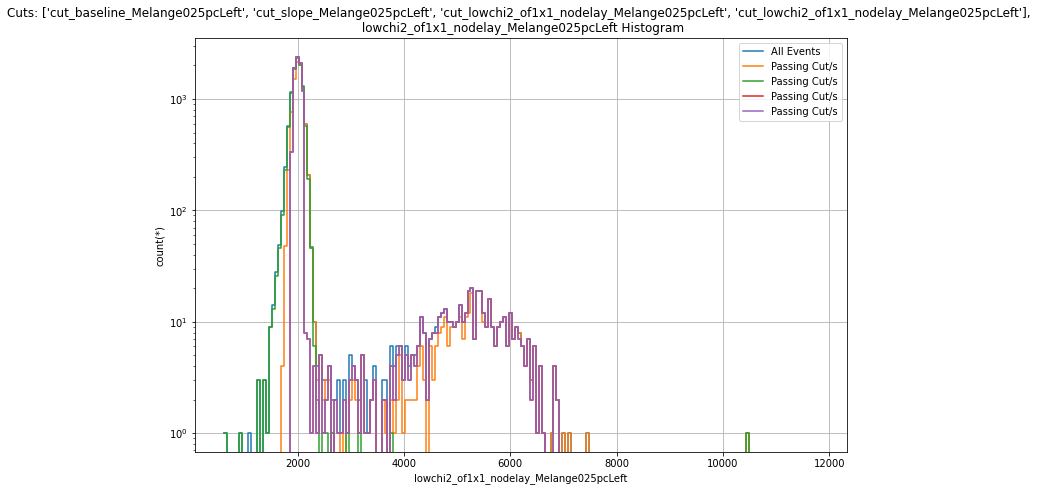

Passage fraction: 0.7480740281590366
Number of events passing cuts: 8448
Number of events failing cuts: 2845
Number of total events: 11293


0.7480740281590366

In [13]:
cut_pars_chi2 = {'percent':0.8}

ofamp_limits = [-0.2e-7, 0.0, 0.5e-7, 1.1e-7]
exceptions_dict = {2: {'val_lower': 1900, 'val_upper': 7000}}

chi2_cut = Semiautocut(df, cut_rq = 'lowchi2_of1x1_nodelay', channel_name='Melange025pcLeft',
                               cut_pars=cut_pars_chi2, ofamp_bins = ofamp_limits, exceptions_dict=exceptions_dict)

chi2cut_mask = chi2_cut.do_cut(lgcdiagnostics=False, 
                                   include_previous_cuts=['cut_baseline_Melange025pcLeft', 'cut_slope_Melange025pcLeft'])
chi2_cut.plot_vs_time(lgchours=True)
chi2_cut.plot_vs_ofamp()
chi2_cut.plot_chi2_vs_ofamp()
chi2_cut.plot_histograms(num_bins=200, include_previous_cuts=True)
chi2_cut.get_passage_fraction(lgcprint=True)


Finally, we can combine these cuts into one master cut. Semiautocuts won't work for this, so I built a very closely related class called Master_semiautocuts.

Master_semiautocuts takes a list of cuts and combines them together.

In [14]:
cuts_list = ['cut_baseline_Melange025pcLeft',
            'cut_slope_Melange025pcLeft',
            'cut_lowchi2_of1x1_nodelay_Melange025pcLeft']

MSAC = MasterSemiautocuts(df, cuts_list, 'Melange025pcLeft')
MSAC.combine_cuts()

Similarly, we can do diagnostic plots to look at all the data together:

/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:856: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):
/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:861: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(yexpression):


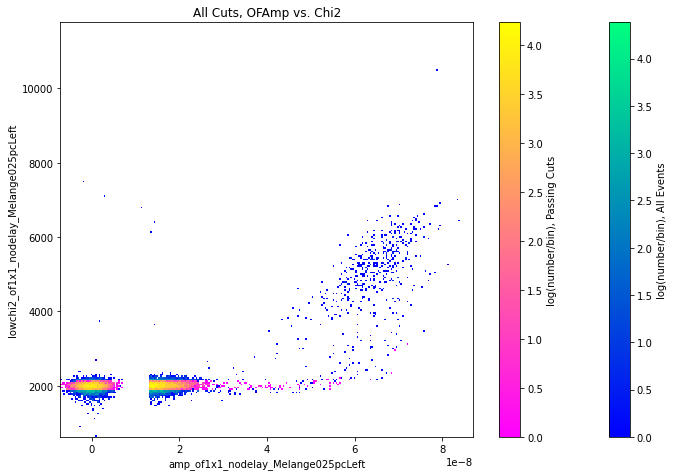

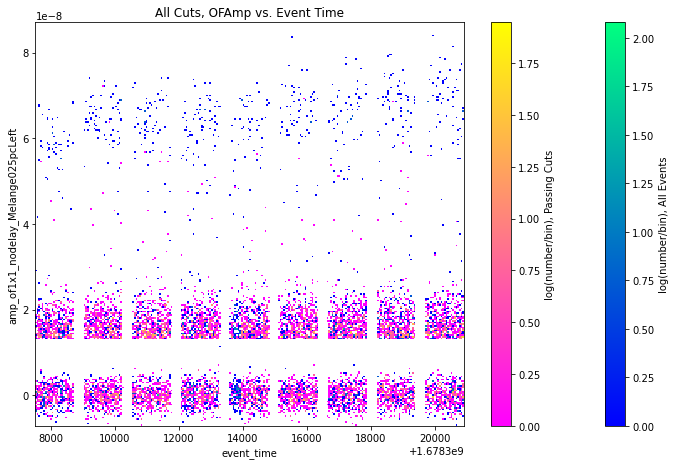

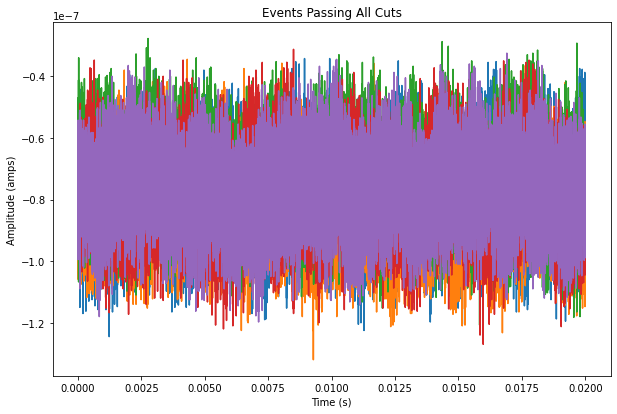

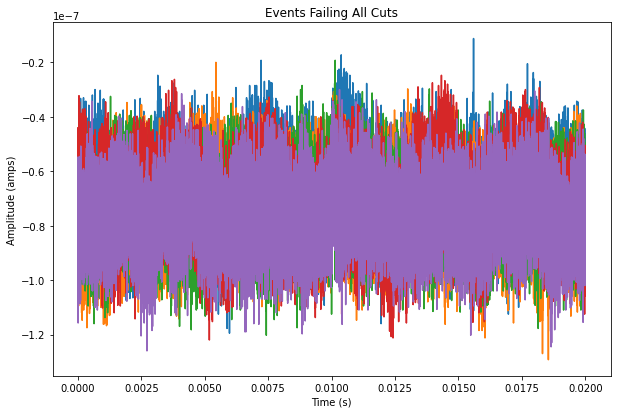

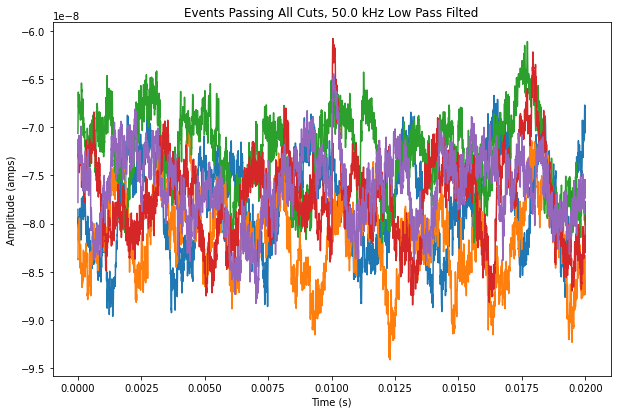

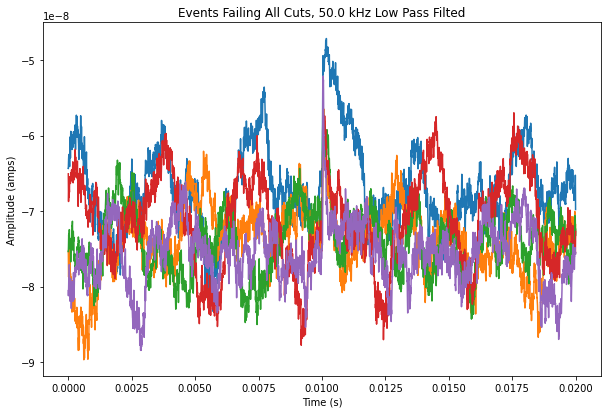

In [15]:
MSAC.plot_chi2_vs_ofamp()
MSAC.plot_ofamp_vs_time()
MSAC.plot_example_events(5, 2, path_to_triggered_data, lp_freq=50e3)

It looks like all our saturated events failed our cuts, specifically because they don't pass the slope cut. We can solve this by just pasing all events over a saturation threshold:

/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:856: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(xexpression):
/home/roger/.local/lib/python3.6/site-packages/vaex/viz/mpl.py:861: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(yexpression):


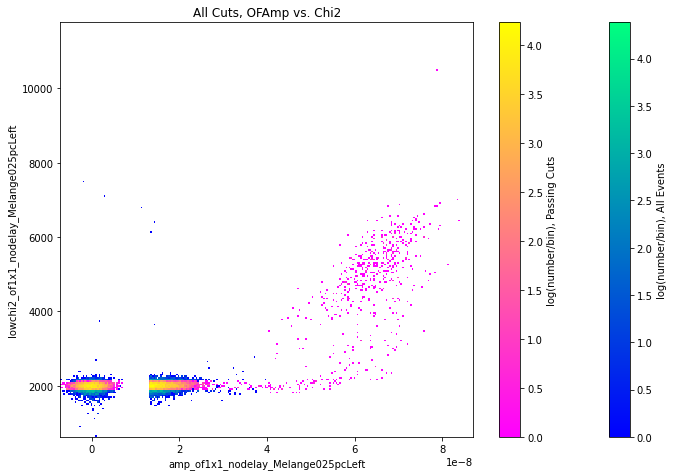

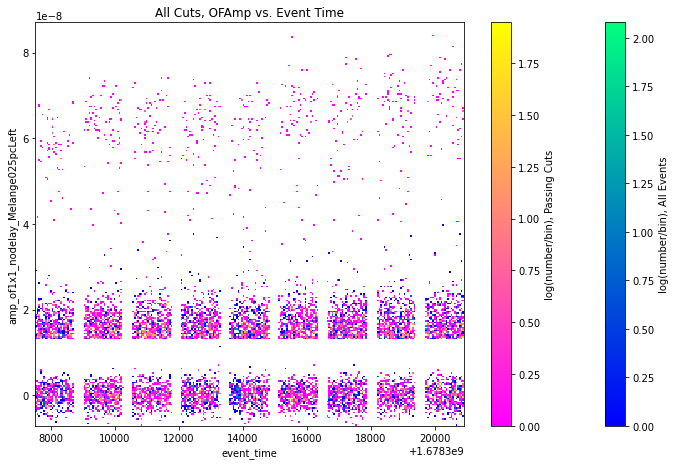

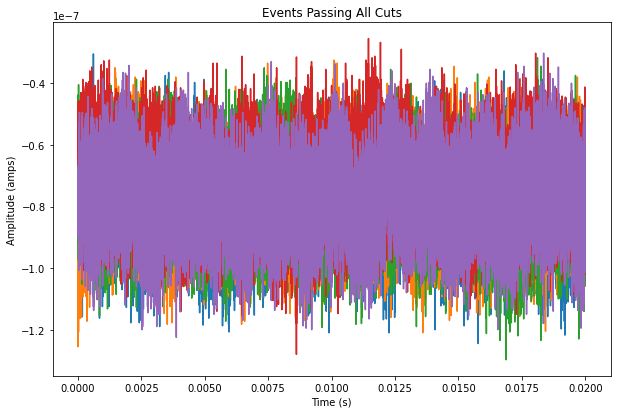

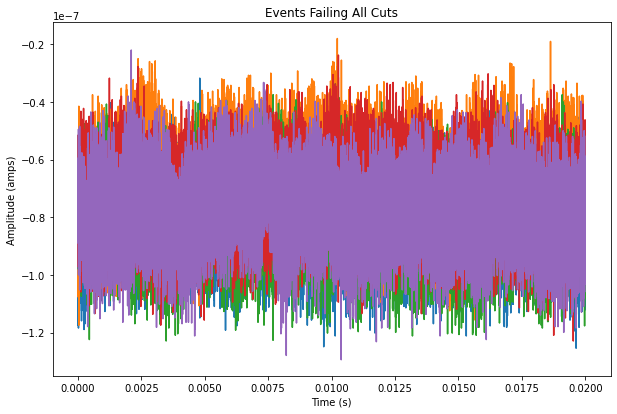

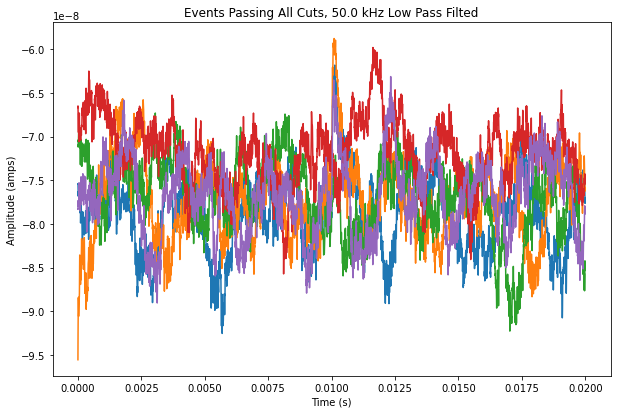

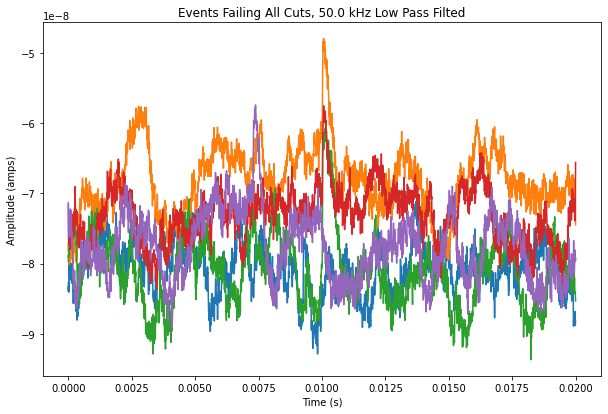

In [16]:
MSAC.combine_cuts(sat_pass_threshold=0.4e-7)

MSAC.plot_chi2_vs_ofamp()
MSAC.plot_ofamp_vs_time()
MSAC.plot_example_events(5, 2, path_to_triggered_data, lp_freq=50e3)

Now, we might want to actually use these cuts. To make plots of only events that pass these cuts, we can use the vaex selection functionality, and select only events where cuts_all_[channel_name] are true:

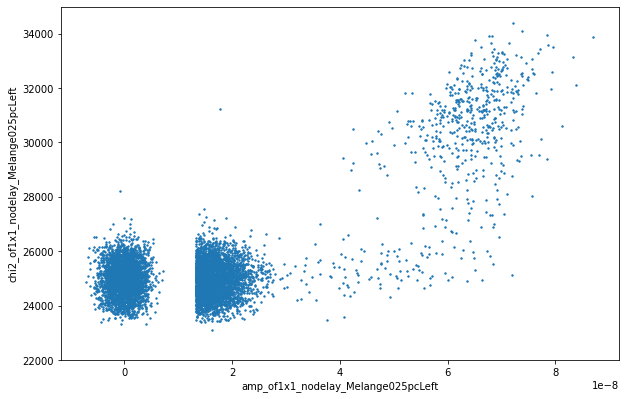

In [17]:
df.viz.scatter(df.amp_of1x1_nodelay_Melange025pcLeft, df.chi2_of1x1_nodelay_Melange025pcLeft, 
               selection='cut_all_Melange025pcLeft', s = 2)
plt.ylim(22000, 35000)
plt.show()